In [15]:
from influxdb_client import InfluxDBClient
import seaborn as sns
import pickle

In [16]:
# Verbindungsparameter
url = 'http://tig.influxdb.local' # A modification in /etc/hosts might be required
token = "securetoken"
org = "influxdata"
bucket = "default"

client = InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()
query = f'''
from(bucket: "{bucket}") 
|> range(start: -8h)
|> filter(fn: (r) => r["_measurement"] == "http")
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''
dataframe = query_api.query_data_frame(query, org=org)

In [17]:

print("Database Query returned: " + str(len(dataframe)) + " elements!")
display('Type: ' + str(type(dataframe)), 'Dataframe Shape: ' + str(dataframe.shape), dataframe.head())

Database Query returned: 2880 elements!


"Type: <class 'pandas.core.frame.DataFrame'>"

'Dataframe Shape: (2880, 2954)'

,result,table,_start,_stop,_time,_measurement,host,url,10838_days_0_icon,10838_days_0_moonPhase,...,10840_forecast2_surfacePressure_51,10840_forecast2_surfacePressure_52,10840_forecast2_surfacePressure_53,10840_forecast2_surfacePressure_54,10840_forecast2_surfacePressure_55,10840_forecast2_surfacePressure_6,10840_forecast2_surfacePressure_7,10840_forecast2_surfacePressure_8,10840_forecast2_surfacePressure_9,10840_forecast2_timeStep
0,_result,0,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:10+00:00,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...,1.0,6.0,...,10139.0,10128.0,10125.0,10140.0,10154.0,10101.0,10120.0,10120.0,10116.0,10800000.0
1,_result,0,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:20+00:00,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...,1.0,6.0,...,10139.0,10128.0,10125.0,10140.0,10154.0,10101.0,10120.0,10120.0,10116.0,10800000.0
2,_result,0,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:30+00:00,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...,1.0,6.0,...,10139.0,10128.0,10125.0,10140.0,10154.0,10101.0,10120.0,10120.0,10116.0,10800000.0
3,_result,0,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:40+00:00,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...,1.0,6.0,...,10139.0,10128.0,10125.0,10140.0,10154.0,10101.0,10120.0,10120.0,10116.0,10800000.0
4,_result,0,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:50+00:00,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...,1.0,6.0,...,10139.0,10128.0,10125.0,10140.0,10154.0,10101.0,10120.0,10120.0,10116.0,10800000.0


In [18]:
dataframe = dataframe.interpolate() # TODO: use polymomial instead of the default linear interpolation
cols_to_drop = dataframe.columns[dataframe.columns.str.contains('forecast')]
dataframe.drop(cols_to_drop, axis=1, inplace=True)
print(dataframe.dtypes.value_counts())
display(dataframe.select_dtypes(include='float64').head(5))
display(dataframe.select_dtypes(include='object').head(5))
display(dataframe.select_dtypes(include='datetime64[ns, UTC]').head(5))
display(dataframe.select_dtypes(include='int64').head(5))

dataframe = dataframe.select_dtypes(include='float64')

float64                260
object                   4
datetime64[ns, UTC]      3
int64                    1
Name: count, dtype: int64


/tmp/ipykernel_5557/3905226762.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dataframe = dataframe.interpolate() # TODO: use polymomial instead of the default linear interpolation


,10838_days_0_icon,10838_days_0_moonPhase,10838_days_0_moonrise,10838_days_0_moonset,10838_days_0_precipitation,10838_days_0_sunrise,10838_days_0_sunset,10838_days_0_sunshine,10838_days_0_temperatureMax,10838_days_0_temperatureMin,...,10840_days_9_moonset,10840_days_9_precipitation,10840_days_9_sunrise,10840_days_9_sunset,10840_days_9_sunshine,10840_days_9_temperatureMax,10840_days_9_temperatureMin,10840_days_9_windDirection,10840_days_9_windGust,10840_days_9_windSpeed
0,1.0,6.0,1.722293e+12,1.722262e+12,4.0,1.722225e+12,1.722280e+12,8330.0,261.0,113.0,...,1.723061e+12,0.0,1.723003e+12,1.723056e+12,4520.0,248.0,157.0,2530.0,278.0,111.0
1,1.0,6.0,1.722293e+12,1.722262e+12,4.0,1.722225e+12,1.722280e+12,8330.0,261.0,113.0,...,1.723061e+12,0.0,1.723003e+12,1.723056e+12,4520.0,248.0,157.0,2530.0,278.0,111.0
2,1.0,6.0,1.722293e+12,1.722262e+12,4.0,1.722225e+12,1.722280e+12,8330.0,261.0,113.0,...,1.723061e+12,0.0,1.723003e+12,1.723056e+12,4520.0,248.0,157.0,2530.0,278.0,111.0
3,1.0,6.0,1.722293e+12,1.722262e+12,4.0,1.722225e+12,1.722280e+12,8330.0,261.0,113.0,...,1.723061e+12,0.0,1.723003e+12,1.723056e+12,4520.0,248.0,157.0,2530.0,278.0,111.0
4,1.0,6.0,1.722293e+12,1.722262e+12,4.0,1.722225e+12,1.722280e+12,8330.0,261.0,113.0,...,1.723061e+12,0.0,1.723003e+12,1.723056e+12,4520.0,248.0,157.0,2530.0,278.0,111.0


,result,_measurement,host,url
0,_result,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...
1,_result,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...
2,_result,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...
3,_result,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...
4,_result,http,telegraf-polling-service,https://dwd.api.proxy.bund.dev/v30/stationOver...


,_start,_stop,_time
0,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:10+00:00
1,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:20+00:00
2,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:30+00:00
3,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:40+00:00
4,2024-07-29 07:12:09.552573+00:00,2024-07-29 15:12:09.552573+00:00,2024-07-29 07:12:50+00:00


,table
0,0
1,0
2,0
3,0
4,0


In [19]:
nan_or_zero_present = dataframe.isnull().values.any() or (dataframe == 0).values.any()
print("Are there any NaN or zero values in the DataFrame?")
print(nan_or_zero_present)

total_nan_or_zero_count = dataframe.isnull().sum().sum() + (dataframe == 0).sum().sum()
print("\nTotal number of NaN or zero values in the DataFrame:")
print(total_nan_or_zero_count)

Are there any NaN or zero values in the DataFrame?
True

Total number of NaN or zero values in the DataFrame:
54288


<class 'pandas.core.frame.DataFrame'>


,10838_days_0_icon,10838_days_0_moonPhase,10838_days_0_moonrise,10838_days_0_moonset,10838_days_0_precipitation,10838_days_0_sunrise,10838_days_0_sunset,10838_days_0_sunshine,10838_days_0_temperatureMax,10838_days_0_temperatureMin,...,10840_days_9_moonset,10840_days_9_precipitation,10840_days_9_sunrise,10840_days_9_sunset,10840_days_9_sunshine,10840_days_9_temperatureMax,10840_days_9_temperatureMin,10840_days_9_windDirection,10840_days_9_windGust,10840_days_9_windSpeed
10838_days_0_icon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10838_days_0_moonPhase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10838_days_0_moonrise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10838_days_0_moonset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10838_days_0_precipitation,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,...,NaN,1.0,NaN,NaN,-1.0,-1.0,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840_days_9_temperatureMax,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,NaN,...,NaN,-1.0,NaN,NaN,1.0,1.0,NaN,-1.0,NaN,NaN
10840_days_9_temperatureMin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10840_days_9_windDirection,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,...,NaN,1.0,NaN,NaN,-1.0,-1.0,NaN,1.0,NaN,NaN
10840_days_9_windGust,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

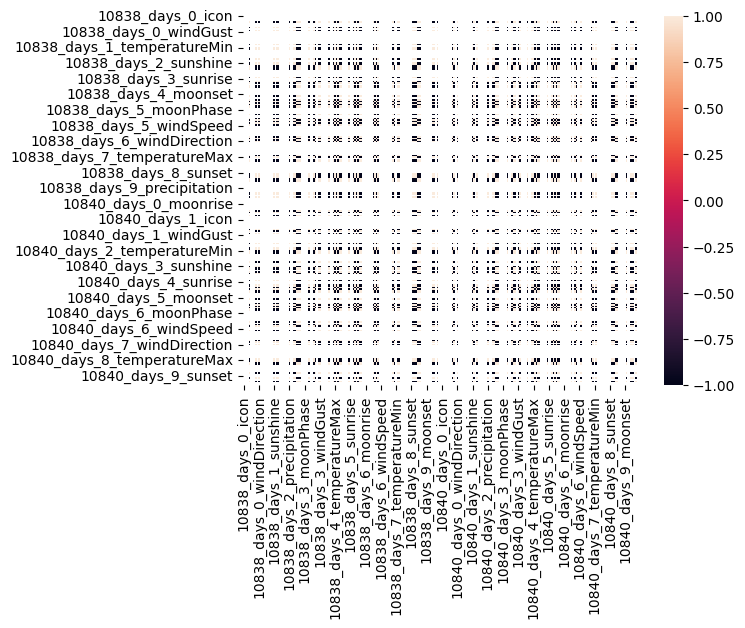

In [20]:
corr_matrix = dataframe.corr()
print(type(corr_matrix))
display(corr_matrix)
display(sns.heatmap(corr_matrix))

<Axes: >

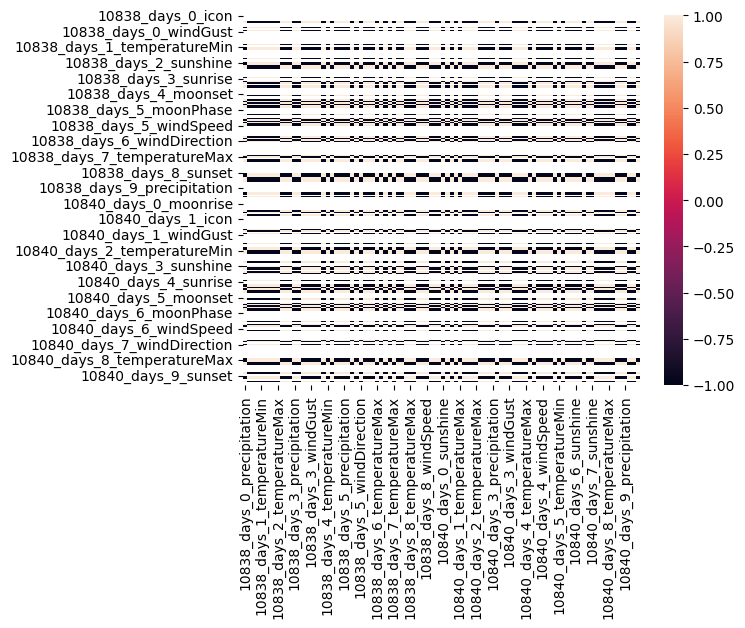

In [21]:
all_nan_columns = corr_matrix.columns[corr_matrix.isna().all()]
df_without_all_nan = corr_matrix.drop(columns=all_nan_columns)
display(sns.heatmap(df_without_all_nan))

In [22]:
display(dataframe[all_nan_columns])
display(dataframe.drop(columns=all_nan_columns))
print(all_nan_columns)

,10838_days_0_icon,10838_days_0_moonPhase,10838_days_0_moonrise,10838_days_0_moonset,10838_days_0_sunrise,10838_days_0_sunset,10838_days_0_sunshine,10838_days_0_temperatureMin,10838_days_0_windGust,10838_days_0_windSpeed,...,10840_days_8_windSpeed,10840_days_9_icon,10840_days_9_moonPhase,10840_days_9_moonrise,10840_days_9_moonset,10840_days_9_sunrise,10840_days_9_sunset,10840_days_9_temperatureMin,10840_days_9_windGust,10840_days_9_windSpeed
0,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
1,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
2,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
3,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
4,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
2876,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
2877,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
2878,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0


,10838_days_0_precipitation,10838_days_0_temperatureMax,10838_days_0_windDirection,10838_days_1_sunshine,10838_days_1_temperatureMin,10838_days_1_windDirection,10838_days_2_precipitation,10838_days_2_sunshine,10838_days_2_temperatureMax,10838_days_2_temperatureMin,...,10840_days_7_windDirection,10840_days_8_sunshine,10840_days_8_temperatureMax,10840_days_8_temperatureMin,10840_days_8_windDirection,10840_days_8_windGust,10840_days_9_precipitation,10840_days_9_sunshine,10840_days_9_temperatureMax,10840_days_9_windDirection
0,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
1,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
2,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
3,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
4,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,10.0,260.0,740.0,7730.0,128.0,1890.0,1.0,5490.0,284.0,186.0,...,2450.0,4690.0,246.0,152.0,2430.0,296.0,1.0,4460.0,247.0,2540.0
2876,10.0,260.0,740.0,7730.0,128.0,1890.0,1.0,5490.0,284.0,186.0,...,2450.0,4690.0,246.0,152.0,2430.0,296.0,1.0,4460.0,247.0,2540.0
2877,10.0,260.0,740.0,7730.0,128.0,1890.0,1.0,5490.0,284.0,186.0,...,2450.0,4690.0,246.0,152.0,2430.0,296.0,1.0,4460.0,247.0,2540.0
2878,10.0,260.0,740.0,7730.0,128.0,1890.0,1.0,5490.0,284.0,186.0,...,2450.0,4690.0,246.0,152.0,2430.0,296.0,1.0,4460.0,247.0,2540.0


Index(['10838_days_0_icon', '10838_days_0_moonPhase', '10838_days_0_moonrise',
       '10838_days_0_moonset', '10838_days_0_sunrise', '10838_days_0_sunset',
       '10838_days_0_sunshine', '10838_days_0_temperatureMin',
       '10838_days_0_windGust', '10838_days_0_windSpeed',
       ...
       '10840_days_8_windSpeed', '10840_days_9_icon', '10840_days_9_moonPhase',
       '10840_days_9_moonrise', '10840_days_9_moonset', '10840_days_9_sunrise',
       '10840_days_9_sunset', '10840_days_9_temperatureMin',
       '10840_days_9_windGust', '10840_days_9_windSpeed'],
      dtype='object', length=164)



Columns that only have one unique value:


,10838_days_0_icon,10838_days_0_moonPhase,10838_days_0_moonrise,10838_days_0_moonset,10838_days_0_sunrise,10838_days_0_sunset,10838_days_0_sunshine,10838_days_0_temperatureMin,10838_days_0_windGust,10838_days_0_windSpeed,...,10840_days_8_windSpeed,10840_days_9_icon,10840_days_9_moonPhase,10840_days_9_moonrise,10840_days_9_moonset,10840_days_9_sunrise,10840_days_9_sunset,10840_days_9_temperatureMin,10840_days_9_windGust,10840_days_9_windSpeed
0,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
1,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
2,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
3,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
4,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
2876,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
2877,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0
2878,1.0,6.0,1.722293e+12,1.722262e+12,1.722225e+12,1.722280e+12,8330.0,113.0,278.0,130.0,...,111.0,2.0,0.0,1.723014e+12,1.723061e+12,1.723003e+12,1.723056e+12,157.0,278.0,111.0


,10838_days_0_precipitation,10838_days_0_temperatureMax,10838_days_0_windDirection,10838_days_1_sunshine,10838_days_1_temperatureMin,10838_days_1_windDirection,10838_days_2_precipitation,10838_days_2_sunshine,10838_days_2_temperatureMax,10838_days_2_temperatureMin,...,10840_days_7_windDirection,10840_days_8_sunshine,10840_days_8_temperatureMax,10840_days_8_temperatureMin,10840_days_8_windDirection,10840_days_8_windGust,10840_days_9_precipitation,10840_days_9_sunshine,10840_days_9_temperatureMax,10840_days_9_windDirection
0,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
1,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
2,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
3,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
4,4.0,261.0,760.0,7810.0,129.0,2020.0,13.0,5880.0,296.0,184.0,...,2480.0,4720.0,254.0,157.0,2410.0,278.0,0.0,4520.0,248.0,2530.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,10.0,260.0,740.0,7730.0,128.0,1890.0,1.0,5490.0,284.0,186.0,...,2450.0,4690.0,246.0,152.0,2430.0,296.0,1.0,4460.0,247.0,2540.0
2876,10.0,260.0,740.0,7730.0,128.0,1890.0,1.0,5490.0,284.0,186.0,...,2450.0,4690.0,246.0,152.0,2430.0,296.0,1.0,4460.0,247.0,2540.0
2877,10.0,260.0,740.0,7730.0,128.0,1890.0,1.0,5490.0,284.0,186.0,...,2450.0,4690.0,246.0,152.0,2430.0,296.0,1.0,4460.0,247.0,2540.0
2878,10.0,260.0,740.0,7730.0,128.0,1890.0,1.0,5490.0,284.0,186.0,...,2450.0,4690.0,246.0,152.0,2430.0,296.0,1.0,4460.0,247.0,2540.0


<Axes: >

<class 'pandas.core.indexes.base.Index'> Index(['10838_days_0_precipitation', '10838_days_0_temperatureMax',
       '10838_days_0_windDirection', '10838_days_1_sunshine',
       '10838_days_1_temperatureMin', '10838_days_1_windDirection',
       '10838_days_2_precipitation', '10838_days_2_sunshine',
       '10838_days_2_temperatureMax', '10838_days_2_temperatureMin',
       '10838_days_2_windDirection', '10838_days_2_windGust',
       '10838_days_3_precipitation', '10838_days_3_sunshine',
       '10838_days_3_temperatureMax', '10838_days_3_windDirection',
       '10838_days_3_windGust', '10838_days_4_precipitation',
       '10838_days_4_sunshine', '10838_days_4_temperatureMax',
       '10838_days_4_temperatureMin', '10838_days_4_windDirection',
       '10838_days_4_windGust', '10838_days_4_windSpeed',
       '10838_days_5_precipitation', '10838_days_5_sunshine',
       '10838_days_5_temperatureMax', '10838_days_5_temperatureMin',
       '10838_days_5_windDirection', '10838_days_5_windG

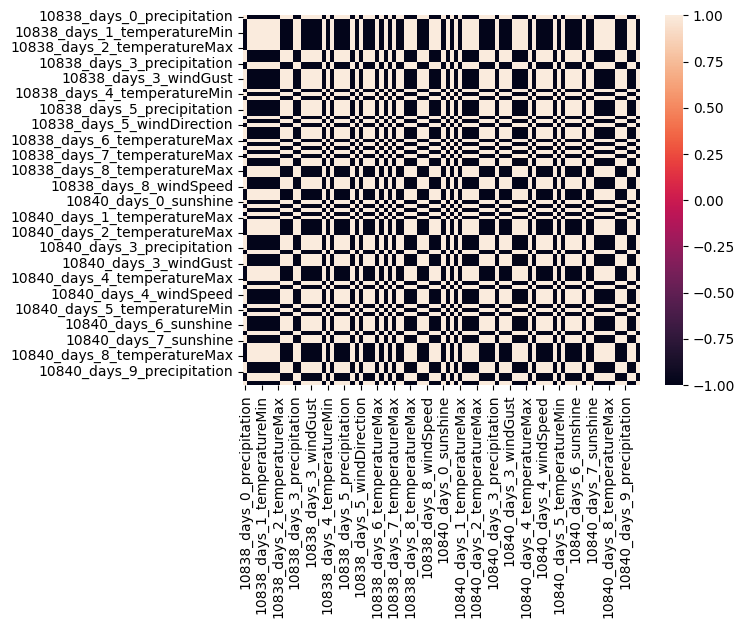

In [23]:
# Identify columns with only one unique value (excluding NaN)
one_value_columns = dataframe.columns[dataframe.nunique(dropna=True) == 1]
print("\nColumns that only have one unique value:")
display(dataframe[one_value_columns])
display(dataframe.drop(columns=one_value_columns))
feature_selection_df = dataframe.drop(columns=one_value_columns)
display(sns.heatmap(feature_selection_df.corr()))

print(type(feature_selection_df.columns), feature_selection_df.columns)

In [24]:
with open('selected_columns.pkl', 'wb') as f:
    pickle.dump(feature_selection_df.columns.to_list(), f)
